# Portfolio Workflow

In [1]:
import logging
import logging.config

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('GenerateBacktest')

import configparser
from platform import python_version
from pathlib import Path

# Project imports
import importlib
import tools.trading_factors_yahoo as alpha_factors
importlib.reload(alpha_factors)
import tools.utils as utils
importlib.reload(utils)
import tools.nonoverlapping_estimator as ai_estimator
importlib.reload(ai_estimator)
import tools.portfolio_optimizer as portfolio_optimizer
importlib.reload(portfolio_optimizer)

import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

2022-08-19 13:35:52,658|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
Sci-Kit version: 0.24.1
Sci-Kit version: 0.24.1
2022-08-19 13:35:56,440|GenerateBacktest|INFO|Python version: 3.8.8
2022-08-19 13:35:56,455|GenerateBacktest|INFO|Pandas version: 1.3.5


In [2]:
config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['BackTest']
ai_alpha_config = config['AIAlpha']

# Price History data and Alphs Factors

In [3]:
price_histories_file_name = default_config['DataDirectory'] + '/' + default_config['PriceHistoriesFileName']
ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config['BetaFactorsFileName']


logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
pricing = price_histories.Close
adv = alpha_factors.AverageDollarVolume(price_histories, 5).factor_data
print(f'You have {len(pricing.columns)} stocks from picing')

logger.info(f'ALPHA_VECTORS_FILE|{ai_alpha_factors_file_name}...')
alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_VECTORS_STOCKS|{len(alpha_vectors.columns)}')

logger.info(f'BEATA_FACTORS_FILE|{beta_factors_file_name}...')
with open(beta_factors_file_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
logger.info(f'DAILY_BETAS|{len(daily_betas)}')

risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])

logger.info(f'OPT|risk_cap|{risk_cap}')
logger.info(f'OPT|weights_max|{weights_max}')
logger.info(f'OPT|weights_min|{weights_min}')

2022-08-19 13:35:56,505|GenerateBacktest|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
You have 501 stocks from picing
2022-08-19 13:35:57,753|GenerateBacktest|INFO|ALPHA_VECTORS_FILE|./data/pre_backtest_alpha_vectors.csv...
2022-08-19 13:35:57,955|GenerateBacktest|INFO|ALPHA_VECTORS_STOCKS|501
2022-08-19 13:35:57,955|GenerateBacktest|INFO|BEATA_FACTORS_FILE|./data/daily_beta.pickle...
2022-08-19 13:35:59,674|GenerateBacktest|INFO|DAILY_BETAS|1007
2022-08-19 13:35:59,674|GenerateBacktest|INFO|OPT|risk_cap|0.08
2022-08-19 13:35:59,674|GenerateBacktest|INFO|OPT|weights_max|0.15
2022-08-19 13:35:59,674|GenerateBacktest|INFO|OPT|weights_min|0.0


In [4]:
def get_lambda(average_dollar_volume):
    adv = average_dollar_volume.replace(np.nan, 1.0e4)
    adv = adv.replace(0.0, 1.0e4)
    return 0.1 / adv

def get_total_transaction_costs(h0, h_star, tc_lambda):
    return np.dot( (h_star - h0) ** 2, tc_lambda)

# Back test AI Alpha and Daily Betas to produce optimal weights

2022-08-19 13:35:59,816|GenerateBacktest|INFO|OPT|2021-08-19 00:00:00|2022-08-11 00:00:00


Dates:   0%|          | 0/50 [00:00<?, ? Portfolio Optimization/s]

2022-08-19 13:53:11,049|GenerateBacktest|INFO|OPT_PORT_RETURN|12.88%
2022-08-19 13:53:11,112|GenerateBacktest|INFO|OPT|PROCEED|12.88%


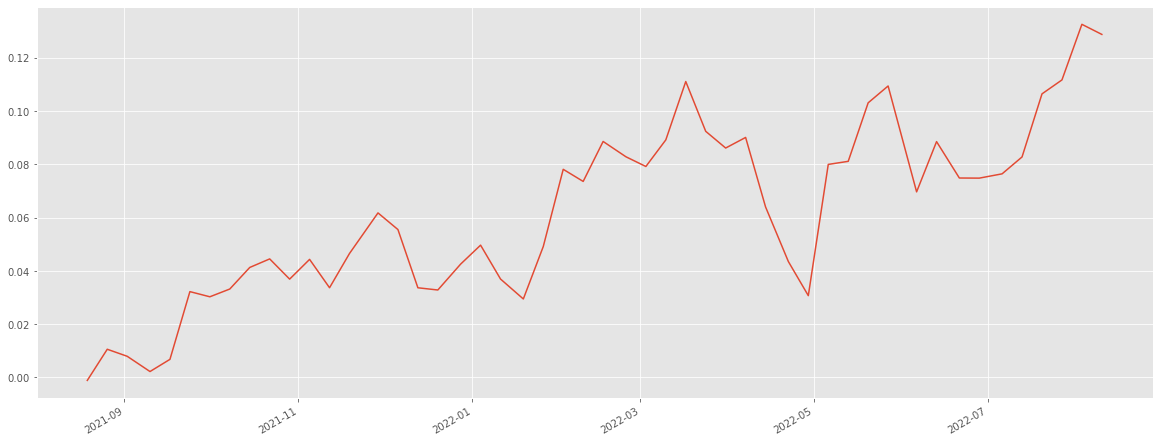

In [5]:
returns = alpha_factors.FactorReturns(price_histories).factor_data
dlyreturn_n_days_delay = int(ai_alpha_config['ForwardPredictionDays'])
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
logger.info(f'OPT|{start_date}|{end_date}')
tc_lambda = get_lambda(adv)

current_holdings = pd.Series(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)

min_viable_port_return = float(default_config['min_viable_port_return'])
opt_date_returns = {}
opt_date_tc = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit=' Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = portfolio_optimizer.OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    new_holdings = optimal_weights['optimalWeights']
    opt_date_returns[opt_date] = (new_holdings * est_return).sum()
    # trading costs
    opt_date_tc[opt_date] = get_total_transaction_costs(current_holdings, new_holdings, tc_lambda.loc[opt_date])
    current_holdings = new_holdings

port_return = round(np.sum(list(opt_date_returns.values())) * 100, 2)
logger.info(f'OPT_PORT_RETURN|{port_return}%')
pd.Series(opt_date_returns).cumsum().plot()
if port_return >= min_viable_port_return:
    logger.info(f'OPT|PROCEED|{port_return}%')
else:
    logger.warn(f'OPT|STOP|{port_return}')
    raise RuntimeError(f'Backtest indicates this strategy needs more work! ({port_return})') from None
    


In [ ]:
tc_ser = pd.Series(opt_date_tc)
re_ser = pd.Series(opt_date_returns)
net_ret = re_ser + tc_ser

In [ ]:
net_ret.cumsum().plot()

In [ ]:
np.sum(net_ret)

In [ ]:
np.sum(re_ser)


## TODO:

- For go forward situations, save all the information to be used to put in buy/sell orders